In [85]:
%matplotlib inline

In [86]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio

In [ ]:
### Starry configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [87]:
### Read in data
M0642_4101 = readsav('2M0642+4101_calibch1_bin5_ap_opt.sav')
time_M0642_4101 = np.array(M0642_4101['bint'][:,0],dtype='float64')
flux_M0642_4101 = np.array(M0642_4101['binflux'][:,0],dtype='float64')
peakp_M0642_4101 = np.array(M0642_4101['peakp'],dtype='float64')
name_M0642_4101=M0642_4101['targ_name'].decode('utf-8')

## Calculate the Error
fluxerr_M0642_4101 = np.zeros_like(flux_M0642_4101) + np.std(flux_M0642_4101 - np.roll(flux_M0642_4101, 1))/np.sqrt(2)

In [88]:
### Instantiate a map so we can do inference on this dataset

map = starry.Map(ydeg=8, reflected=False)
map.obl = 0
map.inc = 90

In [89]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux_M0642_4101, C=fluxerr_M0642_4101**2)

In [90]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [91]:
### More map variables

nrot=max(time_M0642_4101)/10.11 # Calculate the number of rotations
npts = len(time_M0642_4101) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time_M0642_4101, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [92]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 362 ms, sys: 318 ms, total: 680 ms
Wall time: 804 ms


In [93]:
map.show(colorbar=True, projection="moll",file="2M0642+4101/M0642+4101_ydeg8.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


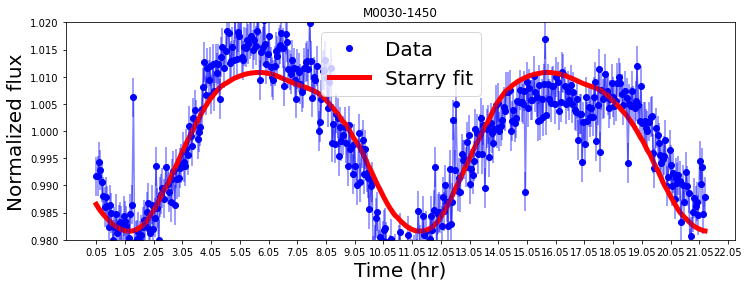

In [94]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("M0030-1450")
plt.plot(time_M0642_4101, flux_M0642_4101,label="Data",linestyle="none",marker="o",color="blue")
plt.ylim(0.98,1.02)
plt.plot(time_M0642_4101, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(time_M0642_4101, flux_M0642_4101, fluxerr_M0642_4101,alpha=0.5,color="blue")
plt.xticks(np.arange(min(time_M0642_4101), max(time_M0642_4101)+1, 1.0))
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("M0642_4101_LightCurve_ydeg8.jpg")

In [95]:
### Delete the first outlier point

index = 27

flux_M0642_4101 = np.delete(flux_M0642_4101,index)
time_M0642_4101 = np.delete(time_M0642_4101,index)
fluxerr_M0642_4101 = np.delete(fluxerr_M0642_4101, index)
flux_M0642_4101 = np.delete(flux_M0642_4101, index)

In [96]:
### Split into individual rotations

time_M0642_4101_rot0 = time_M0642_4101[0:211]
flux_M0642_4101_rot0 = flux_M0642_4101[0:211]
fluxerr_M0642_4101_0 = fluxerr_M0642_4101[0:211]
fluxfitted_M0642_4101_rot0 = []

time_M0642_4101_rot1 = time_M0642_4101[211:426]
flux_M0642_4101_rot1 = flux_M0642_4101[211:426]
fluxerr_M0642_4101_1 = fluxerr_M0642_4101[211:426]
fluxfitted_M0642_4101_rot1 = []

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)


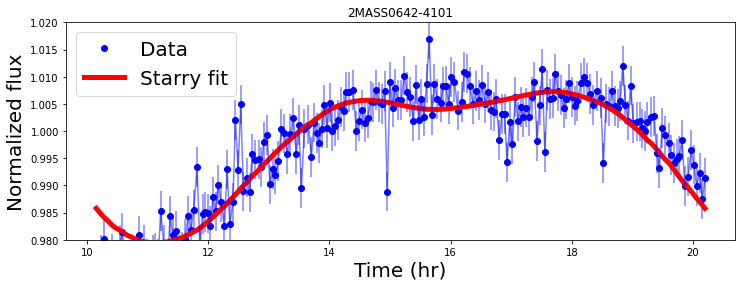

In [99]:
## Instantiate the map
map = starry.Map(ydeg=8, reflected=False)
map.obl = 0
map.inc = 90
map.set_data(flux_M0642_4101_rot1 ,C=fluxerr_M0642_4101_1**2)

## Other map parameters
mu = np.empty(map.Ny)
mu[0] = 1
mu[1:] = 0
L = np.empty(map.Ny)
L[0] = 1e0
L[1:] = 1e-5
map.set_prior(L=L)
nrot=1
npts = len(time_M0642_4101_rot1)
theta = np.linspace(0, 360 * nrot, npts)
kwargs = dict(theta=theta)
mu, cho_cov = map.solve(**kwargs)
map.show(colorbar=True,figsize=(10,10), projection="moll",dpi=500,file="2M0642+4101/Maps/2M0642_4101_map2_ydeg8.jpg")
    
## Saving fitted flux to a new array
fluxfitted_M0642_4101_rot1 = map.flux(**kwargs)
    
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2MASS0642-4101")
plt.plot(time_M0642_4101_rot1, flux_M0642_4101_rot1,label="Data",linestyle="none",marker="o",color="blue")
plt.ylim(0.98,1.02)
plt.plot(time_M0642_4101_rot1, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(time_M0642_4101_rot1, flux_M0642_4101_rot1, fluxerr_M0642_4101_1,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0642+4101/LightCurves/2M0642_4101_curve2.jpg")

In [100]:
### Merged array with all the fitted data

fluxfitted_M0642_4101 = []
fluxfitted_M0642_4101 = np.concatenate((fluxfitted_M0642_4101_rot0,fluxfitted_M0642_4101_rot1))

timefitted_M0642_4101 = []
timefitted_M0642_4101 = np.concatenate((time_M0642_4101_rot0,time_M0642_4101_rot1))

fluxerr_M0642_4101 = []
fluxerr_M0642_4101 = np.concatenate((fluxerr_M0642_4101_0,fluxerr_M0642_4101_1))

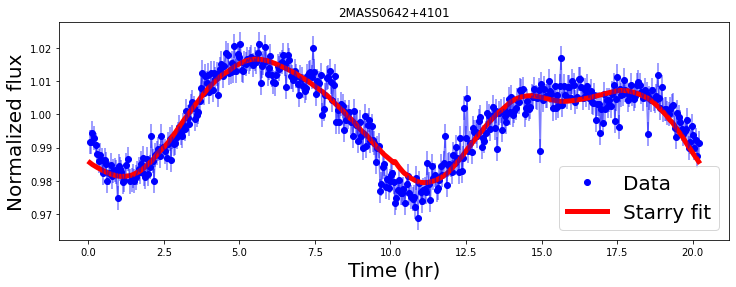

In [101]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2MASS0642+4101")
plt.plot(timefitted_M0642_4101, flux_M0642_4101[0:426],label="Data",linestyle="none",marker="o",color="blue")
#plt.ylim(0.98,1.02)
plt.plot(timefitted_M0642_4101, fluxfitted_M0642_4101,label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(timefitted_M0642_4101, flux_M0642_4101[0:426], fluxerr_M0642_4101[0:426],alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0642+4101_StarryFitted_ydeg8.jpg")

In [102]:
#### Make maps

map.show(colorbar=True,figsize=(10,10), projection="moll",dpi=500,file="2M0642+4101/Maps/2M0642+4101_StarryFitted_Map_ydeg8.jpg")

/opt/anaconda3/envs/new-starry/lib/python3.7/site-packages/starry/_plotting.py:64: RuntimeWarning: invalid value encountered in true_divide
  2 + 2 * np.cos(2 * theta)
